## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


## Data Preprocessing

### Buzasi Data

#### Import Tar file and Extract Postage Stamps 

In [2]:
import tarfile
my_tar = tarfile.open('C:/Users/ptgri/Gyrochronology/Files/tess_postage_stamps.tar')
my_tar.extractall('./my_folder')
my_tar.close()


#### Write Postage Stamps to .txt file 

In [3]:
import os
os.chdir('C:/Users/ptgri/Gyrochronology/Code/my_folder')

with open("Buzasi.txt", "w") as outfile:
    def write_text_file(file_path):
        with open(file_path) as f:
            contents = f.read()
            outfile.write(contents)
            outfile.write('\n')
    for file in os.listdir():
        if file.endswith(".txt"):
            file_path = f"{'C:/Users/ptgri/Gyrochronology/Code/my_folder'}\{file}"
            write_text_file(file_path)


#### Import and process .txt file as .csv file

In [4]:
Buzasi = pd.read_csv('C:/Users/ptgri/Gyrochronology/Code/my_folder/Buzasi.txt',header=None, sep=' ', quotechar='"', skip_blank_lines=False)
Buzasi[['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25']] = (Buzasi[0].astype(str).str.split(',', expand=True).astype(float))
Buzasi = Buzasi.drop(columns=[0])
Buzasi = Buzasi.fillna(0)
Buzasi = pd.read_csv('C:/Users/ptgri/Gyrochronology/Files/test.csv')


#### Zero-padding to ensure images have equal dimensions, then puts each image in a single row, and creates a NumPy array   

In [5]:
padded_matrix = []
i = 0
j = 0
k = 0
N = 3912 #total number of objects
M = 3887 #objects with valid images
for k in range(M):
    count = Buzasi.groupby((Buzasi['1'] == 0).cumsum()).cumcount(ascending=False)+1
    j = i + count[i]
    shape = np.shape(Buzasi.iloc[i:j])
    padded_array = np.zeros((27, 25))
    padded_array[:shape[0],:shape[1]] = Buzasi.iloc[i:j]
    padded_matrix.append(padded_array)
    i = j + 1
    k = k + 1
padded_matrix = np.array(padded_matrix)
padded_matrix = padded_matrix.reshape(M,27*25)


#### Visualize 5 random samples at once

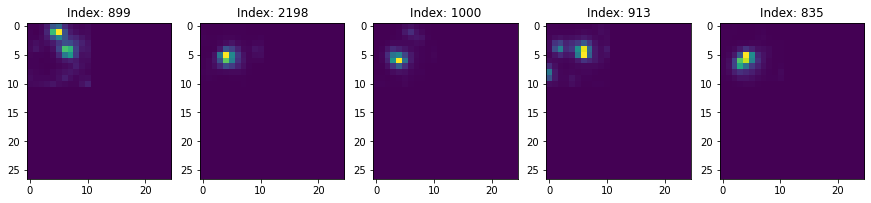

In [6]:
from random import randint
ind = [randint(0,2541),randint(0,2541),randint(0,2541),randint(0,2541),randint(0,2541)]
fig = plt.figure(figsize=(15,15))
for j in range(len(ind)):
    ax = fig.add_subplot(1,5,j+1)
    ax.imshow(padded_matrix[ind[j]].reshape(27,25))
    plt.title('Index: '+str(ind[j]+1))
plt.show()


#### Filtering images with bad data

In [7]:
bad_image = [110376, 11490327, 27014182, 54926434, 87480403, 94367286, 105438311, 125802413, 267624955,
             298017097, 302158903, 332680754, 354825513, 373139866, 382422098, 382422180, 399665349,
             410205809, 416233532, 427733653, 441709021, 441804568, 443616529, 447823435, 458343311]


### Oswalt Data

In [8]:
df = pd.read_excel('C:/Users/ptgri/Gyrochronology/Files/TESS_Oswalt.xlsx',skiprows=3)
df = df.iloc[: , :17]
df = df[df.TIC.isin(bad_image) == False]


In [9]:
df['ANR'] = ""
df.loc[df['SNR'] >= 4.0, 'ANR'] = 1
df.loc[df['SNR'] < 4.0, 'ANR'] = 0

df['Peaks'] = 1
df.loc[df['Mult [M#]'].str.contains('M', na=False), 'Peaks'] = 0

df['Rotators'] = 1
df.loc[df['Rot [R]'].str.contains('R', na=False), 'Rotators'] = 0

df['Pulsators'] = 1
df.loc[df['Pulse [P]'].str.contains('P', na=False), 'Pulsators'] = 0

df['Flares'] = 1
df.loc[df['Flare [F]'].str.contains('F', na=False), 'Flares'] = 0

df['Eclipses'] = 1
df.loc[df['Ecl [E]'].str.contains('E', na=False), 'Eclipses'] = 0

df['Discs'] = 1
df.loc[df['Disc [D]'].str.contains('D', na=False), 'Discs'] = 0

df['Blends'] = 1
df.loc[df['Blend [B]'] == 'B', 'Blends'] = 0
df.loc[df['Blend [B]'] == '?', 'Blends'] = 0
df.loc[df['Blend [B]'] == 'B?', 'Blends'] = 0

df['Trails'] = 1
df.loc[df['Trail [T]'] == 'T', 'Trails'] = 0
df.loc[df['Trail [T]'] == '?', 'Trails'] = 0
df.loc[df['Trail [T]'] == 'T?', 'Trails'] = 0

df['Sky Background'] = 1
df.loc[df['Sky [S]'] == 'S', 'Sky Background'] = 0
df.loc[df['Sky [S]'] == '?', 'Sky Background'] = 0
df.loc[df['Sky [S]'] == 'S?', 'Sky Background'] = 0

df['Aperture'] = 1
df.loc[df['Apert [A]'] == 'A', 'Aperture'] = 0
df.loc[df['Apert [A]'] == '?', 'Aperture'] = 0
df.loc[df['Apert [A]'] == 'A?', 'Aperture'] = 0

df['Quality'] = 0
df.loc[df['Redo (X)'] == 'X', 'Quality'] = 0
df.loc[df['Redo (X)'] == 'OK', 'Quality'] = 1
df.loc[df['Redo (X)'] == 'OK?', 'Quality'] = 1
df.loc[df['Redo (X)'] == 'OK??', 'Quality'] = 1


### Carina Data

In [10]:
df1 = pd.read_excel('C:/Users/ptgri/Gyrochronology/Files/TESS_Carina.xlsx',skiprows=3)
df1 = df1.iloc[: , :18]
df1 = df1[df1.TIC.isin(bad_image) == False]


In [11]:
df1['ANR'] = ""
df1.loc[df1['SNR'] >= 4.0, 'ANR'] = 1
df1.loc[df1['SNR'] < 4.0, 'ANR'] = 0

df1['Peaks'] = 1
df1.loc[df1['Mult P [M#]'].str.contains('M', na=False), 'Peaks'] = 0

df1['Rotators'] = 1
df1.loc[df1['Rot [R]'].str.contains('R', na=False), 'Rotators'] = 0

df1['Pulsators'] = 1
df1.loc[df1['Pulse [P]'].str.contains('P', na=False), 'Pulsators'] = 0

df1['Flares'] = 1
df1.loc[df1['Flare [F]'].str.contains('F', na=False), 'Flares'] = 0

df1['Eclipses'] = 1
df1.loc[df1['Ecl [E]'].str.contains('E', na=False), 'Eclipses'] = 0

df1['Discs'] = 1
df1.loc[df1['Disc [D]'].str.contains('D', na=False), 'Discs'] = 0

df1['Blends'] = 1
df1.loc[df1['Blend [B]'] == 'B', 'Blends'] = 0
df1.loc[df1['Blend [B]'] == '?', 'Blends'] = 0
df1.loc[df1['Blend [B]'] == 'B?', 'Blends'] = 0

df1['Trails'] = 1
df1.loc[df1['Trail [T]'] == 'T', 'Trails'] = 0
df1.loc[df1['Trail [T]'] == '?', 'Trails'] = 0
df1.loc[df1['Trail [T]'] == 'T?', 'Trails'] = 0

df1['Sky Background'] = 1
df1.loc[df1['Sky [S]'] == 'S', 'Sky Background'] = 0
df1.loc[df1['Sky [S]'] == '?', 'Sky Background'] = 0
df1.loc[df1['Sky [S]'] == 'S?', 'Sky Background'] = 0

df1['Aperture'] = 1
df1.loc[df1['Apert [A]'] == 'A', 'Aperture'] = 0
df1.loc[df1['Apert [A]'] == '?', 'Aperture'] = 0
df1.loc[df1['Apert [A]'] == 'A?', 'Aperture'] = 0

df1['Quality'] = 0
df1.loc[df1['Redo (X)'] == 'OK', 'Quality'] = 1
df1.loc[df1['Redo (X)'] == 'OK?', 'Quality'] = 1


### Attribute Selection

In [12]:
print('Please input target attribute of choice:\n0. Quality\n1. Aperture\n2. Sky Background\n3. Trails\n4. Blends\n5. Discs\n6. Eclipses\n7. Flares\n8. Pulsators\n9. Rotators\n10. Peaks\n')
choice = int(input("Choice:"))
if choice == 0:
    df = df[['Quality']].reset_index()
    df1 = df1[['Quality']].reset_index()
elif choice == 1:
    df = df[['Aperture']].reset_index()
    df1 = df1[['Aperture']].reset_index()
elif choice == 2:
    df = df[['Sky Background']].reset_index()
    df1 = df1[['Sky Background']].reset_index()
elif choice == 3:
    df = df[['Trails']].reset_index()
    df1 = df1[['Trails']].reset_index()
elif choice == 4:
    df = df[['Blends']].reset_index()
    df1 = df1[['Blends']].reset_index()
elif choice == 5:
    df = df[['Discs']].reset_index()
    df1 = df1[['Discs']].reset_index()
elif choice == 6:
    df = df[['Eclipses']].reset_index()
    df1 = df1[['Eclipses']].reset_index()
elif choice == 7:
    df = df[['Flares']].reset_index()
    df1 = df1[['Flares']].reset_index()
elif choice == 8:
    df = df[['Pulsators']].reset_index()
    df1 = df1[['Pulsators']].reset_index()
elif choice == 9:
    df = df[['Rotators']].reset_index()
    df1 = df1[['Rotators']].reset_index()
elif choice == 10:
    df = df[['Peaks']].reset_index()
    df1 = df1[['Peaks']].reset_index()
else:
    df = df[['ANR']].reset_index()
    df1 = df1[['ANR']].reset_index()


Please input target attribute of choice:
0. Quality
1. Aperture
2. Sky Background
3. Trails
4. Blends
5. Discs
6. Eclipses
7. Flares
8. Pulsators
9. Rotators
10. Peaks

Choice:0


### Data Selection

In [13]:
print('Whose data do you want to load?:\n0. Oswalt\n1. Carina\n')
dat = int(input("Choice:"))
if dat == 0:
    y = df.to_numpy()
    y = y[:,1:]
    y = y.astype(int)
    X = padded_matrix
    print('Size of X:',X.shape,'\nSize of y:',y.shape)
elif dat == 1:
    y = df1.to_numpy()
    y = y[:,1:]
    y = y.astype(int)
    X = padded_matrix
    print('Size of X:',X.shape,'\nSize of y:',y.shape)


Whose data do you want to load?:
0. Oswalt
1. Carina

Choice:0
Size of X: (3887, 675) 
Size of y: (3887, 1)


# Machine Learning Algorithms

## K-Nearest Neighbor Classification

### Splitting Data

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify = y, random_state = 1)


### Initial Prediction Model

In [15]:
KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)
ypred_train = KNN.predict(X_train)
print("Training accuracy:",accuracy_score(y_train,ypred_train))
ypred_test = KNN.predict(X_test)
print("Testing accuracy:",accuracy_score(y_test,ypred_test))


Training accuracy: 0.8639433901576069
Testing accuracy: 0.8187660668380463


### K-fold cross validation to find the best model

In [16]:
k = 5
kf = KFold(n_splits=k)

Performance = np.empty([k,50])
count = 0
for train, val in kf.split(X_train):
    #training data
    train_X = X_train[train]
    train_y = y_train[train]

    #validation data
    val_X = X_train[val]
    val_y = y_train[val]

    for j in range(1,51):
        KNN = KNeighborsClassifier(n_neighbors = j)
        KNN.fit(train_X, train_y)

        #Predicting
        ypred_val = KNN.predict(val_X)
        Performance[count, j-1] = accuracy_score(val_y, ypred_val)
    count = count + 1


### Optimizing Model

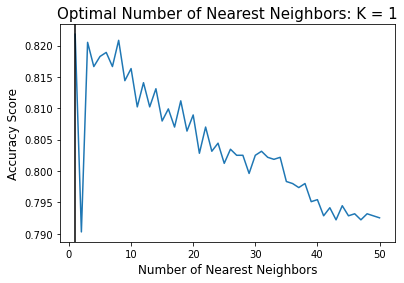

In [17]:
avg_performance = np.mean(Performance, axis=0)
best_model = np.argmax(avg_performance)
plt.plot(np.arange(1,len(avg_performance)+1),avg_performance)
plt.axvline(x=best_model+1, color = 'k')
plt.title('Optimal Number of Nearest Neighbors: K = '+str(best_model+1),size = 15)
plt.xlabel('Number of Nearest Neighbors',size = 12)
plt.ylabel('Accuracy Score',size = 12)
plt.show()


### Final Model Performance

In [18]:
KNN = KNeighborsClassifier(n_neighbors=(best_model+1))
KNN.fit(X_train,y_train)
ypred_test = KNN.predict(X_test)
accuracy_score(y_test,ypred_test)


0.8367609254498715

### Confusion Matrix and Classification Report

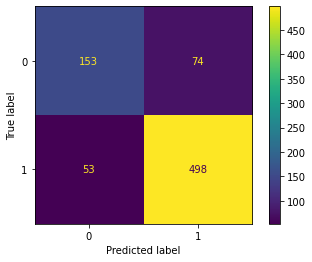

True positive: 498 	False positive: 74 
True negative: 153 	False negative: 53 

              precision    recall  f1-score   support

           0       0.74      0.67      0.71       227
           1       0.87      0.90      0.89       551

    accuracy                           0.84       778
   macro avg       0.81      0.79      0.80       778
weighted avg       0.83      0.84      0.83       778



In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, ypred_test).ravel()
cm = confusion_matrix(y_test, ypred_test, labels=KNN.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=KNN.classes_)
disp.plot()
plt.show()
print('True positive:',tp,'\tFalse positive:',fp,'\nTrue negative:',tn,'\tFalse negative:',fn,'\n')
print(classification_report(y_test, ypred_test))


## Random Forest Classification

### Splitting Data

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify = y, random_state = 1)


### Initial Prediction Model

In [21]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)
ypred_train = rfc.predict(X_train)
print("Training accuracy:",accuracy_score(y_train,ypred_train))
ypred_test = rfc.predict(X_test)
print("Testing accuracy:",accuracy_score(y_test,ypred_test))


Training accuracy: 0.9971051785139916
Testing accuracy: 0.8457583547557841


### Use Validation Error to select best model

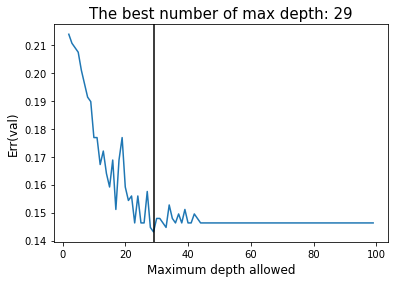

In [22]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify = y_train, random_state=1)
per = []
for j in np.arange(2,100):
    rfc = RandomForestClassifier(random_state = 1, max_depth = j)
    rfc.fit(X_tr,y_tr)
    pred = rfc.predict(X_val)
    error = 1 - accuracy_score(y_val,pred)
    per.append(error)
opt_depth = np.arange(2,100)[np.argmin(np.array(per))]
plt.plot(np.arange(2,100),per)
plt.axvline(x=opt_depth, color = 'k')
plt.title('The best number of max depth: '+str(opt_depth),size = 15)
plt.xlabel('Maximum depth allowed',size = 12)
plt.ylabel('Err(val)',size = 12)
plt.show()


### Final Model Performance

In [23]:
rfc = RandomForestClassifier(random_state = 1, max_depth = opt_depth)
rfc.fit(X_train,y_train)
ypred_test = rfc.predict(X_test)
accuracy_score(y_test,ypred_test)


0.8470437017994858

### Confusion Matrix and Classification Report

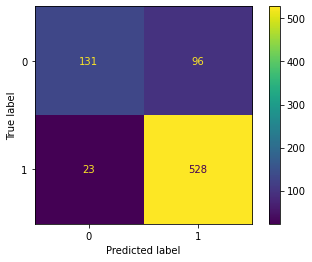

True positive: 528 	False positive: 96 
True negative: 131 	False negative: 23 

              precision    recall  f1-score   support

           0       0.85      0.58      0.69       227
           1       0.85      0.96      0.90       551

    accuracy                           0.85       778
   macro avg       0.85      0.77      0.79       778
weighted avg       0.85      0.85      0.84       778



In [24]:
tn, fp, fn, tp = confusion_matrix(y_test, ypred_test).ravel()
cm = confusion_matrix(y_test, ypred_test, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()
plt.show()
print('True positive:',tp,'\tFalse positive:',fp,'\nTrue negative:',tn,'\tFalse negative:',fn,'\n')
print(classification_report(y_test, ypred_test))


## Decision Tree Classifier

### Splitting Data

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify = y, random_state = 1)


### Initial Prediction Model

In [26]:
clf = DecisionTreeClassifier(random_state = 1)
clf.fit(X_train, y_train)
ypred_train = clf.predict(X_train)
print("Training accuracy:",accuracy_score(y_train,ypred_train))
ypred_test = clf.predict(X_test)
print("Testing accuracy:",accuracy_score(y_test,ypred_test))


Training accuracy: 0.9971051785139916
Testing accuracy: 0.7737789203084833


### Information on the produced Decision Tree 

In [27]:
print('Tree depth:', clf.get_depth())
print('Number of leaves:', clf.get_n_leaves())


Tree depth: 39
Number of leaves: 296


### Optimizing Model

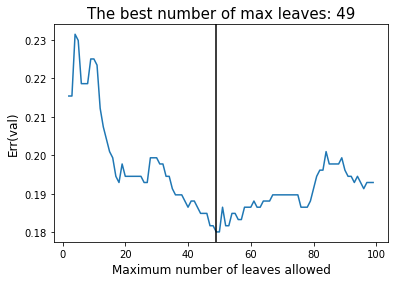

In [28]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 1)

per = []
for j in np.arange(2,100):
    clf = DecisionTreeClassifier(random_state = 1, max_leaf_nodes = j)
    clf.fit(X_tr,y_tr)
    pred = clf.predict(X_val)
    error = 1 - accuracy_score(y_val,pred)
    per.append(error)

opt_nodes = np.arange(2,100)[np.argmin(np.array(per))]
plt.plot(np.arange(2,100),per)
plt.axvline(x=opt_nodes, color = 'k')
plt.title('The best number of max leaves: '+str(opt_nodes),size = 15)
plt.xlabel('Maximum number of leaves allowed',size = 12)
plt.ylabel('Err(val)',size = 12)
plt.show()


### Final Model Performance

In [29]:
clf = DecisionTreeClassifier(random_state = 1, max_leaf_nodes = opt_nodes)
clf.fit(X_train,y_train)
ypred_test = clf.predict(X_test)
accuracy_score(y_test,ypred_test)


0.800771208226221

### Confusion Matrix and Classification Report

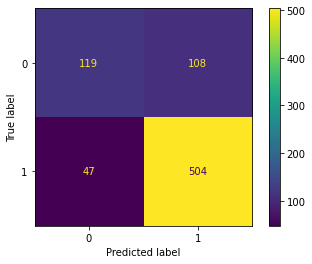

True positive: 504 	False positive: 108 
True negative: 119 	False negative: 47 

              precision    recall  f1-score   support

           0       0.72      0.52      0.61       227
           1       0.82      0.91      0.87       551

    accuracy                           0.80       778
   macro avg       0.77      0.72      0.74       778
weighted avg       0.79      0.80      0.79       778

Tree depth: 11 		Number of leaves: 49


In [30]:
tn, fp, fn, tp = confusion_matrix(y_test, ypred_test).ravel()
cm = confusion_matrix(y_test, ypred_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()
print('True positive:',tp,'\tFalse positive:',fp,'\nTrue negative:',tn,'\tFalse negative:',fn,'\n')
print(classification_report(y_test, ypred_test))
print('Tree depth:', clf.get_depth(),'\t\tNumber of leaves:',clf.get_n_leaves())


### Accuracy Boosting with AdaBoost

In [31]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes = opt_nodes, random_state = 1), n_estimators=100, random_state = 1)
abc.fit(X_train, y_train)
ypred_train = abc.predict(X_train)
print("Training accuracy with boost:",accuracy_score(y_train, ypred_train))
ypred_test = abc.predict(X_test)
print("Testing accuracy with boost:",accuracy_score(y_test, ypred_test))


Training accuracy with boost: 0.9971051785139916
Testing accuracy with boost: 0.8316195372750642
